In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [12]:
train_set = torchvision.datasets.CIFAR10('./datasets', train=True,
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./datasets', train=False,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                           shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


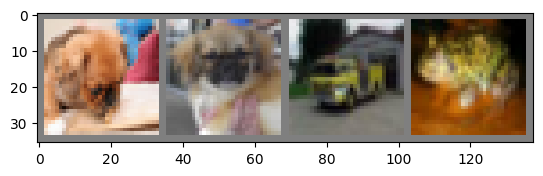

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()
    
image_iter = iter(train_loader)
images, _ = next(image_iter)
imshow(torchvision.utils.make_grid(images[:4]))

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cpu')
print(device)

cuda:0


In [15]:
class Bottleneck(nn.Module):
    """
    Dense Block
    这里的growth_rate=out_channels, 就是每个Block自己输出的通道数。
    先通过1x1卷积层，将通道数缩小为4 * growth_rate，然后再通过3x3卷积层降低到growth_rate。
    """
    expansion = 4
    
    def __init__(self, in_channels, growth_rate):
        super(Bottleneck, self).__init__()
        zip_channels = self.expansion * growth_rate
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(True),
            nn.Conv2d(zip_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = torch.cat([out, x], 1)
        return out       

In [16]:
class Transition(nn.Module):
    """
    改变维数的Transition层
    先通过1x1的卷积层减少channels，再通过2x2的平均池化层缩小feature-map
    """
    def __init__(self, in_channels, out_channels):
        super(Transition, self).__init__()
        self.features = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(2)
        )
        
    def forward(self, x):
        out = self.features(x)
        return out

In [8]:
class DenseNet(nn.Module):
    """
    Dense Net
    paper中growth_rate取12，维度压缩的参数θ，即reduction取0.5
    且初始化方法为kaiming_normal()
    num_blocks为每段网络中的DenseBlock数量
    DenseNet和ResNet一样也是六段式网络（一段卷积+四段Dense+平均池化层），最后FC层。
    第一段将维数从3变到2 * growth_rate
    
    (3, 32, 32) -> [Conv2d] -> (24, 32, 32) -> [layer1] -> (48, 16, 16) -> [layer2]
  ->(96, 8, 8) -> [layer3] -> (192, 4, 4) -> [layer4] -> (384, 4, 4) -> [AvgPool]
  ->(384, 1, 1) -> [Linear] -> (10)
    
    """
    def __init__(self, num_blocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.reduction = reduction
        
        num_channels = 2 * growth_rate
        
        self.features = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.layer1, num_channels = self._make_dense_layer(num_channels, num_blocks[0])
        self.layer2, num_channels = self._make_dense_layer(num_channels, num_blocks[1])
        self.layer3, num_channels = self._make_dense_layer(num_channels, num_blocks[2])
        self.layer4, num_channels = self._make_dense_layer(num_channels, num_blocks[3], transition=False)
        self.avg_pool = nn.Sequential(
            nn.BatchNorm2d(num_channels),
            nn.ReLU(True),
            nn.AvgPool2d(4),
        )
        self.classifier = nn.Linear(num_channels, num_classes)
        
        self._initialize_weight()
        
    def _make_dense_layer(self, in_channels, nblock, transition=True):
        layers = []
        for i in range(nblock):
            layers += [Bottleneck(in_channels, self.growth_rate)]
            in_channels += self.growth_rate
        out_channels = in_channels
        if transition:
            out_channels = int(math.floor(in_channels * self.reduction))
            layers += [Transition(in_channels, out_channels)]
        return nn.Sequential(*layers), out_channels
    
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
    
    def forward(self, x):
        out = self.features(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [9]:
def DenseNet121():
    return DenseNet([6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet([6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet([6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet([6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet([6,12,24,16], growth_rate=12)

In [10]:
net = densenet_cifar().to(device)
print(net)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

DenseNet(
  (features): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (features): Sequential(
        (0): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
        (5): Conv2

In [11]:
# 测试
x = torch.randn(1, 3, 32, 32).to(device)
y = net(x)
print(y.shape)

torch.Size([1, 10])


In [18]:
lr = 1e-1
momentum = 0.9
weight_decay = 3e-4

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# 论文原文的batch_size设置为64，epoch为300，在训练到50%和75%的epoch的时候，衰减学习率为原先的1/10
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 225])

In [19]:
# Training
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = train_loss / batch_idx
    print('Epoch: %d, train loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss

In [20]:
# Evaluation
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = test_loss / len(test_loader)
    acc = 100. * correct / total
    print('Test Loss: %.6f | Acc: %.3f%% (%d/%d)' % (avg_loss, acc, correct, total))
    return avg_loss


In [15]:
def test(epoch):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    loss = test_loss / batch_idx
    print('Epoch: %d, test loss: %.6f, acc: %.3f%% (%d/%d)' % (epoch, loss, acc, correct, total))
    return loss

In [22]:
load_model = False
if load_model:
    checkpoint = torch.load('./checkpoint/densenet.ckpt')
    net.load_state_dict(checkpoint['net'])
    start_epoch = checkpoint['epoch']
else:
    start_epoch = 0
print('start_epoch: %s' % start_epoch)

start_epoch: 0


In [24]:
for epoch in range(start_epoch, 50):
    train_loss = train(epoch)
    test_loss = test(epoch)
    print('Epoch %d | Train Loss: %.6f | Test Loss: %.6f' % (epoch, train_loss, test_loss))

    scheduler.step(test_loss)  # 如果是 ReduceLROnPlateau 类型的 scheduler


Epoch: 0, train loss: 0.811420, acc: 71.704% (35852/50000)
Test Loss: 0.812396 | Acc: 72.430% (7243/10000)
Epoch 0 | Train Loss: 0.811420 | Test Loss: 0.812396


/root/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1, train loss: 0.618460, acc: 78.474% (39237/50000)
Test Loss: 0.670824 | Acc: 76.590% (7659/10000)
Epoch 1 | Train Loss: 0.618460 | Test Loss: 0.670824
Epoch: 2, train loss: 0.527037, acc: 81.738% (40869/50000)
Test Loss: 0.643536 | Acc: 77.820% (7782/10000)
Epoch 2 | Train Loss: 0.527037 | Test Loss: 0.643536
Epoch: 3, train loss: 0.473353, acc: 83.606% (41803/50000)
Test Loss: 0.545391 | Acc: 81.140% (8114/10000)
Epoch 3 | Train Loss: 0.473353 | Test Loss: 0.545391
Epoch: 4, train loss: 0.427239, acc: 85.168% (42584/50000)
Test Loss: 0.605978 | Acc: 79.720% (7972/10000)
Epoch 4 | Train Loss: 0.427239 | Test Loss: 0.605978
Epoch: 5, train loss: 0.401173, acc: 86.142% (43071/50000)
Test Loss: 0.477661 | Acc: 83.620% (8362/10000)
Epoch 5 | Train Loss: 0.401173 | Test Loss: 0.477661
Epoch: 6, train loss: 0.375443, acc: 87.064% (43532/50000)
Test Loss: 0.573672 | Acc: 80.750% (8075/10000)
Epoch 6 | Train Loss: 0.375443 | Test Loss: 0.573672
Epoch: 7, train loss: 0.356624, acc: 87.

In [ ]:
plot_loss(train_losses, test_losses)